Continuous waveform mode
========================

In this tutorial we will demonstrate continuous waveform mode (see [Continuous waveform mode](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/sequencer.html#continuous-waveform-mode)).
In addition, we will observe the output on an oscilloscope to demonstrate the results.

Setup
-----

First, we are going to import the required packages and connect to the instrument.

In [1]:
#Set up the environment.
import scipy.signal
import math
import json
import matplotlib.pyplot
import numpy

from qblox_instruments import Pulsar

#Close any existing connections to any Pulsar.
Pulsar.close_all()

#Connect to the Pulsar at default IP address.
pulsar = Pulsar("pulsar", "192.168.0.2")

#Reset the instrument for good measure.
pulsar.reset()
print("Status:")
print(pulsar.get_system_state())

Status:
SystemState(status=<SystemStatus.OKAY: 2>, flags=[])


Generate waveforms
------------------

Next, we are going to generate a couple of waveforms that we are going to upload to the instrument in the next step.

In [2]:
#Waveform parameters
waveform_length = 120 #nanoseconds (needs to be a multiple of 4 ns)
    
#Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
                "gaussian": {"data": scipy.signal.gaussian(waveform_length, std=0.12 * waveform_length).tolist(),         "index": 0},
                "sine":     {"data": [math.sin((2 * math.pi / waveform_length) * i ) for i in range(0, waveform_length)], "index": 1},
                "sawtooth": {"data": [(1.0 / (waveform_length)) * i for i in range(0, waveform_length)],                  "index": 2},
                "block":    {"data": [1.0 for i in range(0, waveform_length)],                                            "index": 3}
            }

Let's plot the waveforms to see what we have created.

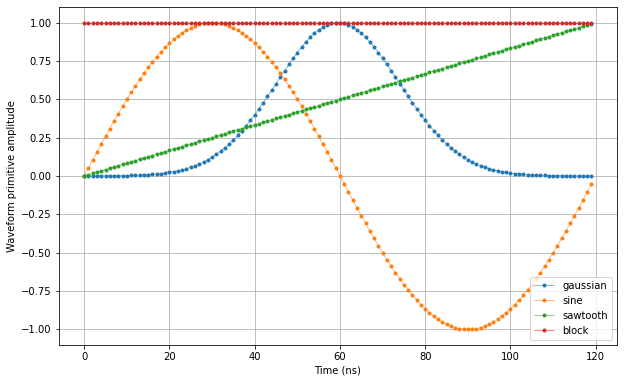

In [3]:
time    = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1,1, figsize=(10, 10/1.61))

for wf, d in waveforms.items():
    ax.plot(time[:len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

matplotlib.pyplot.draw()
matplotlib.pyplot.show()

Upload waveforms
----------------

Now that we know that the waveforms are what we expect them to be, let's upload them to the instrument.
To do this we need to store the waveforms in a JSON file together with a Q1ASM program for the sequence
processor. Since we are going to use continuous waveform mode, the sequence processor will be bypassed 
and the Q1ASM program can be trivial (i.e. `stop`).

In [4]:
#Sequence program.
seq_prog = "stop"

#Check waveform length.
for name in waveforms:
    assert (len(waveforms[name]["data"]) % 4) == 0, "In continuous waveform mode the lenght of a waveform must be a multiple of 4!"

#Add sequence program and waveforms to single dictionary and write to JSON file.
sequence = {"waveforms": waveforms, "weights": {}, "acquisitions": {}, "program": seq_prog}
with open("cont_wave_mode.json", 'w', encoding='utf-8') as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 and 1, which will drive outputs $\text{O}^{[1-2]}$ and $\text{O}^{[3-4]}$ respectively.

In [5]:
#Upload sequence.
pulsar.sequencer0.sequence("cont_wave_mode.json")
pulsar.sequencer1.sequence("cont_wave_mode.json")

Play waveforms
--------------

The waveforms have been uploaded to the instrument. Now we need to configure the instrument to run in continuous waveform mode. We
do this by setting the following parameters of the sequencers.

In [6]:
#Configure the sequencers to run in continuous waveform mode.
for sequencer in [pulsar.sequencer0, pulsar.sequencer1]:
    sequencer.cont_mode_en_awg_path0(True)
    sequencer.cont_mode_en_awg_path1(True)

#Map sequencers to specific outputs (but first disable all sequencer connections).
for sequencer in pulsar.sequencers:
    for out in range(0, 4):
        if hasattr(sequencer, "channel_map_path{}_out{}_en".format(out%2, out)):
            sequencer.set("channel_map_path{}_out{}_en".format(out%2, out), False)

#If it is a QRM, we only map sequencer 0 to the outputs.
pulsar.sequencer0.channel_map_path0_out0_en(True)
pulsar.sequencer0.channel_map_path1_out1_en(True)
if pulsar.is_qcm_type:
    pulsar.sequencer1.channel_map_path0_out2_en(True)
    pulsar.sequencer1.channel_map_path1_out3_en(True)

#Set specific waveform to specific output.
pulsar.sequencer0.cont_mode_waveform_idx_awg_path0(0) #Gaussian on O1
pulsar.sequencer0.cont_mode_waveform_idx_awg_path1(1) #Sine on O2
pulsar.sequencer1.cont_mode_waveform_idx_awg_path0(2) #Sawtooth on 03
pulsar.sequencer1.cont_mode_waveform_idx_awg_path1(3) #DC on O4

Now let's start playback.

In [7]:
#Arm and start both sequencers.
pulsar.arm_sequencer(0)
pulsar.arm_sequencer(1)
pulsar.start_sequencer()

#Print status of both sequencers (should now say Q1 stopped, because of the stop instruction).
print("Status:")
print(pulsar.get_sequencer_state(0))
print(pulsar.get_sequencer_state(1))

Status:
SequencerState(status=<SequencerStatus.STOPPED: 5>, flags=[])
SequencerState(status=<SequencerStatus.STOPPED: 5>, flags=[])


Check waveforms
---------------

The instrument is now running in continuous waveform mode. Now let's connect an oscilloscope and check the outputs.
We connect all output channels of the Pulsar QCM to four channels of an oscilloscope.
On the scope we are able to see that all waveforms are being generated correctly:

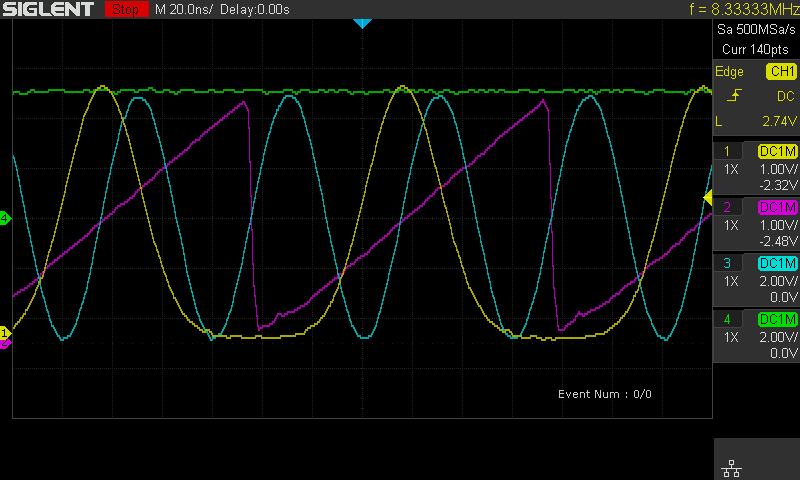

Outputs: Yellow=$\text{O}^{1}$, Blue=$\text{O}^{2}$, Purple=$\text{O}^{3}$ and Green=$\text{O}^{4}$

Stop
----

Finally, let's stop the playback and close the instrument connection.

In [8]:
#Stop both sequencers.
pulsar.stop_sequencer()
    
#Print status of both sequencers (should now say it is stopped).
print("Status:")
print(pulsar.get_sequencer_state(0))
print(pulsar.get_sequencer_state(1))
print()

#Print an overview of the instrument parameters.
print("Snapshot:")
pulsar.print_readable_snapshot(update=True)
    
#Close the instrument connection.
pulsar.close()

Status:
SequencerState(status=<SequencerStatus.STOPPED: 5>, flags=[<SequencerStatusFlags.FORCED_STOP: 2>])
SequencerState(status=<SequencerStatus.STOPPED: 5>, flags=[<SequencerStatusFlags.FORCED_STOP: 2>])

Snapshot:
pulsar:
	parameter                    value
--------------------------------------------------------------------------------
IDN                           :	{'manufacturer': 'qblox', 'model': 'pulsar_qr...
in0_gain                      :	-6 (dB)
in1_gain                      :	-6 (dB)
out0_offset                   :	0 (V)
out1_offset                   :	0 (V)
reference_source              :	internal 
scope_acq_avg_mode_en_path0   :	False 
scope_acq_avg_mode_en_path1   :	False 
scope_acq_sequencer_select    :	0 
scope_acq_trigger_level_path0 :	0 
scope_acq_trigger_level_path1 :	0 
scope_acq_trigger_mode_path0  :	sequencer 
scope_acq_trigger_mode_path1  :	sequencer 
pulsar_sequencer0:
	parameter                       value
----------------------------------------------------